<a href="https://colab.research.google.com/github/cardazuluaga/CINTIA2025/blob/main/Taller_Escenarios_Probabilisticos_ML_DatosReales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller: Generación de Escenarios probabilísticos de Energía Renovable con Aprendizaje Automático

Modelos: **ARIMA** y **RNN**.
El presente cuaderno tiene como propósito explorar el uso de métodos de aprendizaje de máquina para la generación de escenarios probabilísticos de energía renovable a corto plazo, integrando enfoques clásicos y modernos de modelado de series temporales.

La creciente penetración de fuentes de energía renovables —como la solar fotovoltaica y la eólica— introduce un alto grado de variabilidad e incertidumbre en los sistemas eléctricos modernos. A diferencia de las fuentes convencionales, la producción renovable depende de condiciones meteorológicas cambiantes, lo que complica la predicción determinista de su comportamiento.

En este contexto, los operadores de red y modeladores energéticos requieren herramientas que permitan no solo estimar valores esperados de generación, sino también caracterizar la distribución de posibles trayectorias futuras, lo que se conoce como generación de escenarios probabilísticos.

Los enfoques deterministas tradicionales (por ejemplo, modelos de tendencia o regresiones lineales) no capturan adecuadamente la incertidumbre inherente a los procesos naturales, limitando su uso en aplicaciones críticas como:

*   Despacho económico bajo incertidumbre.
*   Planeación de reservas operativas.
*   Evaluación de confiabilidad del sistema.
*   Análisis de riesgo en integración de energías limpias.

Por tanto, surge la necesidad de aplicar métodos estadísticos y de aprendizaje automático que generen escenarios probabilísticos realistas, manteniendo la coherencia temporal y las dependencias dinámicas de la serie.

El uso de técnicas de machine learning para la generación de escenarios permite:

* Capturar no linealidades y dependencias temporales complejas.
* Estimar distribuciones predictivas completas, no solo valores puntuales.
* Propagar de manera explícita la incertidumbre en modelos de decisión y optimización.
* Integrar distintos enfoques (paramétricos, no paramétricos y neuronales) dentro de un mismo marco comparativo.

Estos métodos son esenciales para construir modelos más robustos y adaptativos, capaces de ofrecer predicciones probabilísticas con valor operativo y científico.

Este notebook implementa tres modelos representativos para la generación de escenarios basados en series temporales:

1.   ARIMA (AutoRegressive Integrated Moving Average): Modelo estadístico clásico que combina componentes autoregresivos y de media móvil, ampliamente usado como línea base para pronóstico de series estacionarias. Los escenarios se generan mediante simulación de Monte Carlo sobre los residuales ajustados.
2.  Red Neuronal Recurrente (LSTM con Monte Carlo Dropout): Modelo de aprendizaje profundo capaz de capturar dependencias de largo plazo y no lineales. La incertidumbre se introduce mediante MC Dropout, realizando múltiples predicciones estocásticas para aproximar la distribución posterior.

In [ ]:

# @title Instalación de dependencias (Colab)
# Si estás en Colab, esto instalará/actualizará las librerías necesarias
import sys, subprocess

def pip_install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# Paquetes clave
for pkg in ["numpy", "pandas", "matplotlib", "statsmodels", "scikit-learn", "tensorflow==2.*"]:
    try:
        __import__(pkg.split("==")[0])
    except Exception:
        pip_install(pkg)

!pip install pandas odfpy

In [ ]:
# @title Utilidades y cargue de datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Datos obtenidos de https://pronos.adme.com.uy/gpf.php
data = pd.read_excel('/content/sample_data/gpf_6606288_6615004_horario.ods')
Rene_Energy_series = data[['Valores aproximados a partir de información del SCADA @ 2025-10-07 14:45','Unnamed: 6']]
Rene_Energy_series.columns = ['fecha', 'Psolar']
Rene_Energy_series = Rene_Energy_series[2:]
Rene_Energy_series['Psolar'] = pd.to_numeric(Rene_Energy_series['Psolar'], errors='coerce')
Rene_Energy_series['fecha'] = pd.to_datetime(Rene_Energy_series['fecha'])
Rene_Energy_series['Psolar']= (Rene_Energy_series['Psolar'] - Rene_Energy_series['Psolar'].min()) / (Rene_Energy_series['Psolar'].max() - Rene_Energy_series['Psolar'].min())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453 entries, 2 to 1454
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   1453 non-null   datetime64[ns]
 1   Psolar  1453 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.8 KB


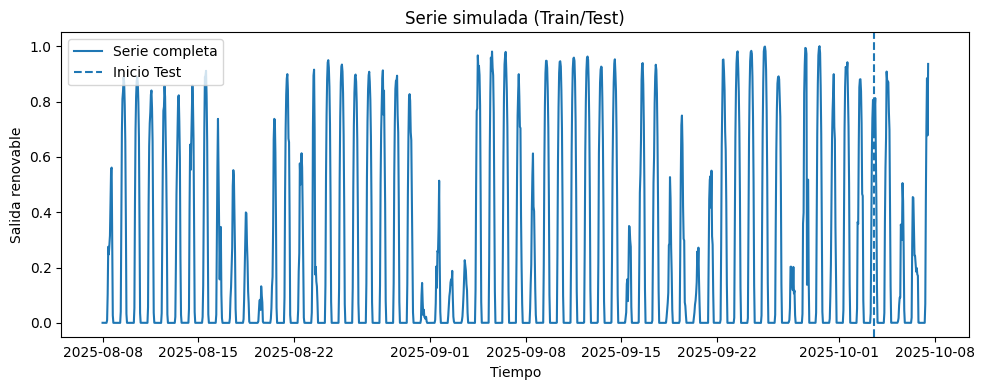

In [ ]:

# @title Utilidades y simulación de datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    eps = 1e-8
    return float(np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100.0)

def interval_metrics(scenarios, y_true, alpha=0.2):
    """Cobertura y ancho del intervalo (1-alpha)."""
    lower = np.quantile(scenarios, q=alpha/2, axis=0)
    upper = np.quantile(scenarios, q=1 - alpha/2, axis=0)
    coverage = float(np.mean((y_true >= lower) & (y_true <= upper)))
    avg_width = float(np.mean(upper - lower))
    return coverage, avg_width, lower, upper

def crps_ensemble(scenarios, y_true):
    """CRPS aproximado para ensambles."""
    X = scenarios  # (M, H)
    M, H = X.shape
    term1 = np.mean(np.abs(X - y_true.reshape(1, -1)), axis=0)
    if M > 100:
        idx = np.random.choice(M, size=100, replace=False)
        Xs = X[idx, :]
    else:
        Xs = X
    diffs = []
    for k in range(H):
        col = Xs[:, k].reshape(-1, 1)
        diff = np.abs(col - col.T)
        diffs.append(np.mean(diff))
    term2 = np.array(diffs)
    crps_t = term1 - 0.5 * term2
    return float(np.mean(crps_t))

# Datos Reales

series = pd.Series(Rene_Energy_series['Psolar'].values, index=Rene_Energy_series['fecha'], name="renewable_output")
H = 24 * 4  # 7 días de horizonte
train = series.iloc[:-H]
test = series.iloc[-H:]


plt.figure(figsize=(10,4))
plt.plot(series.index, series.values, label="Serie completa")
plt.axvline(test.index[0], linestyle="--", label="Inicio Test")
plt.title("Serie simulada (Train/Test)")
plt.xlabel("Tiempo"); plt.ylabel("Energía renovable")
plt.legend(); plt.tight_layout(); plt.show()


**Modelo ARIMA + escenarios Monte Carlo**


Un modelo ARIMA(\(p,d,q\)) combina tres componentes:

1. **Autoregresivo (AR)**: La variable depende de sus valores pasados.
$
AR(p): \quad y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \varepsilon_t
$

2. **Diferenciación (I)**: Hace estacionaria la serie eliminando tendencias.
$
y'_t = \nabla^d y_t = (1 - B)^d y_t
$
donde $B$ es el operador rezago: $B y_t = y_{t-1}$.

3. **Media móvil (MA)**: Modela dependencias en los errores pasados.
$
MA(q): \quad y_t = \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \cdots + \theta_q \varepsilon_{t-q}
$

Combinando los tres componentes:
$
ARIMA(p,d,q): \quad \phi(B)(1-B)^d y_t = \theta(B) \varepsilon_t
$
donde:
- $\phi(B) = 1 - \phi_1 B - \cdots - \phi_p B^p$  
- $\theta(B) = 1 + \theta_1 B + \cdots + \theta_q B^q$

#### Estimación de parámetros

El conjunto de parámetros $\Theta = \{\phi_i, \theta_j, \sigma^2\}$ se estima típicamente **maximizando la verosimilitud** bajo el supuesto de ruido gaussiano:
$
\hat{\Theta} = \arg \max_{\Theta} \; p(y_{1:T} \,|\, \Theta)
$

Con ruido normal e independencia condicional, esto equivale a minimizar el error cuadrático medio:
$
\hat{\Theta} = \arg \min_{\Theta} \sum_{t=1}^{T} (y_t - \hat{y}_t)^2
$

Desde una **perspectiva bayesiana**, los parámetros se tratan como variables aleatorias con prior $p(\Theta)$, y se infieren mediante la distribución posterior:
$
p(\Theta \,|\, y_{1:T}) \propto p(y_{1:T} \,|\, \Theta) \, p(\Theta)
$

De este modo, la estimación se convierte en un problema de **inferencia probabilística** que puede resolverse mediante **MCMC**, **Variational Bayes** o aproximaciones Laplacianas.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:       renewable_output   No. Observations:                 1357
Model:                ARIMA(24, 1, 4)   Log Likelihood                1606.676
Date:                Tue, 07 Oct 2025   AIC                          -3155.352
Time:                        23:56:10   BIC                          -3004.713
Sample:                    08-08-2025   HQIC                         -3098.900
                         - 10-03-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1634      0.214      0.765      0.444      -0.255       0.582
ar.L2         -0.2597      0.265     -0.980      0.327      -0.779       0.260
ar.L3         -0.2127      0.237     -0.896      0.3

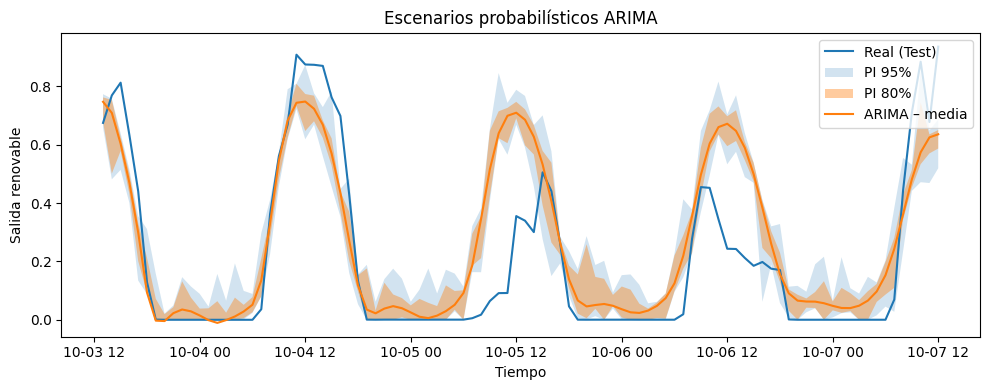

In [ ]:

from statsmodels.tsa.arima.model import ARIMA

arima_order = (24, 1, 4)
arima = ARIMA(train, order=arima_order, enforce_stationarity=False, enforce_invertibility=False)
arima_res = arima.fit()
print(arima_res.summary())
arima_mean = arima_res.forecast(steps=H)

# Residuales in-sample para bootstrap
in_sample_pred = arima_res.predict(start=train.index[0], end=train.index[-1])
residuals = (train - in_sample_pred).dropna().values
if len(residuals) == 0:
    residuals = np.random.normal(0, train.std()*0.1, size=len(train))

M = 10  # Nº de escenarios
boot_eps = np.random.choice(residuals, size=(M, H), replace=True)
arima_scenarios = np.maximum(arima_mean.values.reshape(1, -1) + boot_eps, 0.0)

# Métricas puntuales
rmse_arima = float(np.sqrt(mean_squared_error(test.values, arima_mean.values)))
mae_arima  = float(mean_absolute_error(test.values, arima_mean.values))
mape_arima = mape(test.values, arima_mean.values)

# Métricas probabilísticas
cov80_arima, w80_arima, l80_arima, u80_arima = interval_metrics(arima_scenarios, test.values, alpha=0.2)
cov95_arima, w95_arima, l95_arima, u95_arima = interval_metrics(arima_scenarios, test.values, alpha=0.05)
crps_arima = crps_ensemble(arima_scenarios, test.values)

print("ARIMA – RMSE: %.3f | MAE: %.3f | MAPE: %.2f%%" % (rmse_arima, mae_arima, mape_arima))

plt.figure(figsize=(10,4))
plt.plot(test.index, test.values, label="Real (Test)")
plt.fill_between(test.index, l95_arima, u95_arima, alpha=0.2, label="PI 95%")
plt.fill_between(test.index, l80_arima, u80_arima, alpha=0.4, label="PI 80%")
plt.plot(test.index, arima_mean.values, label="ARIMA – media")
plt.title("Escenarios probabilísticos ARIMA")
plt.xlabel("Tiempo"); plt.ylabel("Salida renovable")
plt.legend(); plt.tight_layout(); plt.show()


### Redes Neuronales Recurrentes (RNN) y LSTM

Las **RNN** modelan dependencias temporales mediante un **estado oculto** $h_t$ que se actualiza con el tiempo:

$
h_t = \sigma(W_{xh} x_t + W_{hh} h_{t-1} + b_h), \qquad
y_t = W_{hy} h_t + b_y
$

donde $\sigma$ es una función de activación no lineal (típicamente tanh o ReLU).

---

#### LSTM (Long Short-Term Memory)

El modelo **LSTM** introduce puertas que controlan el flujo de información y resuelven el problema del *desvanecimiento del gradiente*:

$
\begin{aligned}
f_t &= \sigma(W_f [h_{t-1}, x_t] + b_f) & \text{(puerta de olvido)} \\
i_t &= \sigma(W_i [h_{t-1}, x_t] + b_i), \quad \tilde{C}_t = \tanh(W_C [h_{t-1}, x_t] + b_C) & \text{(puerta de entrada)} \\
C_t &= f_t \odot C_{t-1} + i_t \odot \tilde{C}_t & \text{(memoria)} \\
o_t &= \sigma(W_o [h_{t-1}, x_t] + b_o), \quad h_t = o_t \odot \tanh(C_t) & \text{(puerta de salida)}
\end{aligned}
$

donde:
- $C_t$: estado de celda (memoria de largo plazo)
- $h_t$: estado oculto (salida actual)
- $\odot$: multiplicación elemento a elemento

---

#### Estimación de parámetros

Los parámetros $\Theta = \{W, b\}$ se estiman **minimizando una función de pérdida**, generalmente el error cuadrático medio:
$
\hat{\Theta} = \arg \min_{\Theta} \sum_t (y_t - \hat{y}_t)^2
$

La optimización se realiza mediante **descenso de gradiente estocástico (SGD)** o variantes adaptativas (Adam, RMSprop), usando **retropropagación a través del tiempo (BPTT)**.

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.1156
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0597
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0423
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0376
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0300
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0315
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0275
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0249
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0248
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0229
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0225
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0206
Epoch 13/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0215
Epoch 14/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0194
Epoch 15/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0187
Epoc

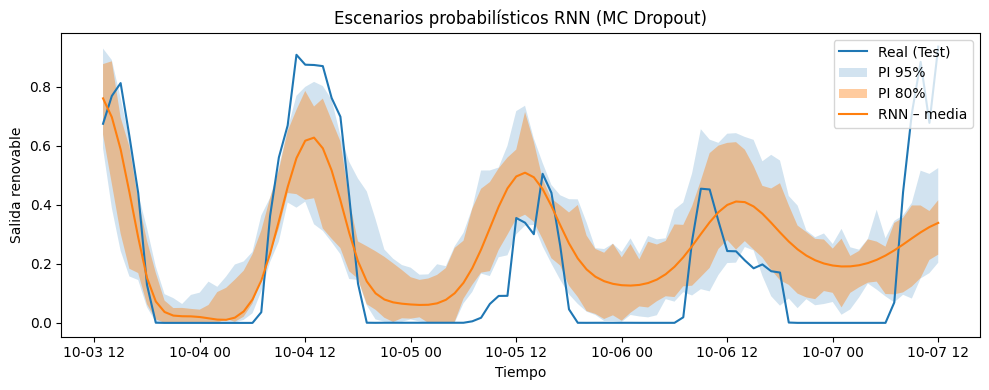

In [ ]:

# @title RNN (LSTM con MC Dropout) + escenarios Monte Carlo
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def make_supervised(s, window):
    X, Y = [], []
    for i in range(len(s) - window):
        X.append(s[i:i+window])
        Y.append(s[i+window])
    return np.array(X), np.array(Y)

window = 24
s_train = train.values.astype("float32")
Xr, Yr = make_supervised(s_train, window)
Xr = Xr.reshape((Xr.shape[0], Xr.shape[1], 1))

tf.random.set_seed(7)
model = keras.Sequential([
    layers.Input(shape=(window, 1)),
    layers.LSTM(32, recurrent_dropout=0.2, return_sequences=True),
    layers.LSTM(32, recurrent_dropout=0.2, return_sequences=True),
    layers.LSTM(32, recurrent_dropout=0.2, return_sequences=False),
    layers.Dropout(0.3),
    layers.Dense(1)
])
model.compile(optimizer="rmsprop", loss="mse")
model.fit(Xr, Yr, epochs=50, batch_size=32, verbose=1)

def rnn_forecast_mean(model, history_vals, horizon):
    hist = history_vals.copy().astype("float32")
    preds = []
    for _ in range(horizon):
        x = hist[-window:].reshape((1, window, 1))
        yhat = model(x, training=False).numpy().ravel()[0]
        preds.append(max(yhat, 0.0))
        hist = np.append(hist, yhat)
    return np.array(preds)

rnn_mean = rnn_forecast_mean(model, s_train, H)

def rnn_mc_paths(model, history_vals, horizon, n_paths):
    paths = np.zeros((n_paths, horizon), dtype="float32")
    for m in range(n_paths):
        hist = history_vals.copy().astype("float32")
        for h in range(horizon):
            x = hist[-window:].reshape((1, window, 1))
            yhat = model(x, training=True).numpy().ravel()[0]  # Dropout activo
            yhat = max(yhat, 0.0)
            paths[m, h] = yhat
            hist = np.append(hist, yhat)
    return paths

M = 10
rnn_scenarios = rnn_mc_paths(model, s_train, H, M)

rmse_rnn = float(np.sqrt(mean_squared_error(test.values, rnn_mean)))
mae_rnn  = float(mean_absolute_error(test.values, rnn_mean))
mape_rnn = mape(test.values, rnn_mean)

cov80_rnn, w80_rnn, l80_rnn, u80_rnn = interval_metrics(rnn_scenarios, test.values, alpha=0.2)
cov95_rnn, w95_rnn, l95_rnn, u95_rnn = interval_metrics(rnn_scenarios, test.values, alpha=0.05)
crps_rnn = crps_ensemble(rnn_scenarios, test.values)

print("RNN – RMSE: %.3f | MAE: %.3f | MAPE: %.2f%%" % (rmse_rnn, mae_rnn, mape_rnn))

plt.figure(figsize=(10,4))
plt.plot(test.index, test.values, label="Real (Test)")
plt.fill_between(test.index, l95_rnn, u95_rnn, alpha=0.2, label="PI 95%")
plt.fill_between(test.index, l80_rnn, u80_rnn, alpha=0.4, label="PI 80%")
plt.plot(test.index, rnn_mean, label="RNN – media")
plt.title("Escenarios probabilísticos RNN (MC Dropout)")
plt.xlabel("Tiempo"); plt.ylabel("Salida renovable")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:

# @title Consolidación de métricas y exportación CSV
point_metrics = pd.DataFrame({
    "Modelo": ["ARIMA(2,1,2)", "RNN (LSTM)"],
    "RMSE": [rmse_arima, rmse_rnn],
    "MAE":  [mae_arima,  mae_rnn],
    "MAPE (%)": [mape_arima, mape_rnn]
}).set_index("Modelo")

prob_metrics = pd.DataFrame({
    "Modelo": ["ARIMA(2,1,2)", "RNN (LSTM)"],
    "Cobertura 80%": [cov80_arima, cov80_rnn],
    "Ancho PI 80%":  [w80_arima,  w80_rnn],
    "Cobertura 95%": [cov95_arima, cov95_rnn],
    "Ancho PI 95%":  [w95_arima,  w95_rnn],
    "CRPS (↓)":      [crps_arima, crps_rnn]
}).set_index("Modelo")

display(point_metrics.round(4))
display(prob_metrics.round(4))

,RMSE,MAE,MAPE (%)
Modelo,,,
"ARIMA(2,1,2)",0.1741,0.1210,47779.6109
RNN (LSTM),0.2172,0.1138,3746.5526


,Cobertura 80%,Ancho PI 80%,Cobertura 95%,Ancho PI 95%,CRPS (↓)
Modelo,,,,,
"ARIMA(2,1,2)",0.3750,0.1049,0.4271,0.1706,0.1027
RNN (LSTM),0.6667,0.1517,0.7188,0.2024,0.1020
